## Training Neural Networks

#### *08 November 2019*
#### *DATA 1010*

In [1]:
include("imports.jl");

Let's begin with an interactive which shows how changes to the parameters influence the output of the neural network. 

In [2]:
include("network-viz.jl")
@manipulate for w in -4:0.1:2
    Ws[1][end, end] = w
    p₁ = network_viz(Ws, bs, x₁, 5)
    p₂ = network_viz(Ws, bs, x₂, -2)
    plot(p₁, p₂, layout = (1, 2), size = (1000, 300))
end

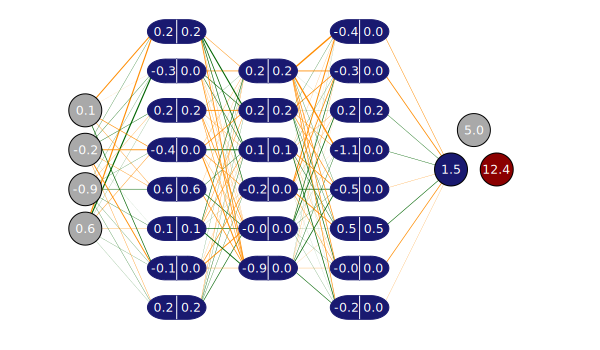

In [3]:
network_viz(Ws, bs, x₁, 5)

## Problem 1

In this exercise, we will explore the neural network training process step by step, working with the example from last time. The neural architecture is as follows:

<center>
    <img src="small-neural-net.svg" width="350px">
</center>

Let's store our parameter values in an ordered dictionary. 

In [4]:
@vars a b c d e f g h i real=true
θ = OrderedDict{Sym,Float64}(a => 3, b => -4, c => -2, d => 4, e => 1, 
                             f => -1, g => 1, h => -4, i => 0);

Let's also define a function for visualization the target function $(x,y) \mapsto x + y^2$ and the neural network.

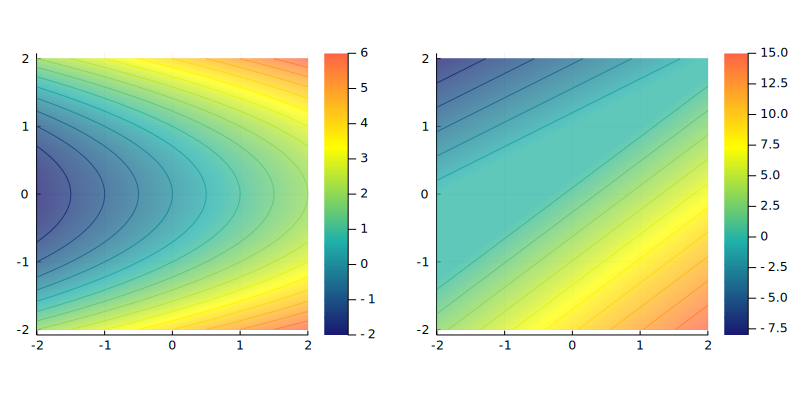

In [5]:
function visualize(θ)
    substitute(x) = float(x(θ...))
    W₁ = map(substitute, [a b; c d])
    W₂ = map(substitute, [e, f]')
    b₁ = map(substitute, [g, h])
    b₂ = substitute(i)
    p1 = heatmap(-2:0.01:2, -2:0.01:2, (x,y) -> x + y^2, 
                 ratio = 1, fillopacity = 0.75)
    contour!(p1, -2:0.01:2, -2:0.01:2, (x,y) -> x + y^2)
    r(x,y) = W₂ * max.(0, W₁*[x, y] + b₁) .+ b₂
    p2 = heatmap(-2:0.01:2, -2:0.01:2, r, fillopacity = 0.75, ratio = 1)
    contour!(p2, -2:0.01:2, -2:0.01:2, r)
    plot(p1, p2, layout = (1, 2), size = (800, 400))
end
visualize(θ)

The idea is to adjust the parameters in a direction that gets us closer to the target function. Let's go ahead and simulate some observations with $(x,y) \mapsto x + y^2$ as the regression function. 

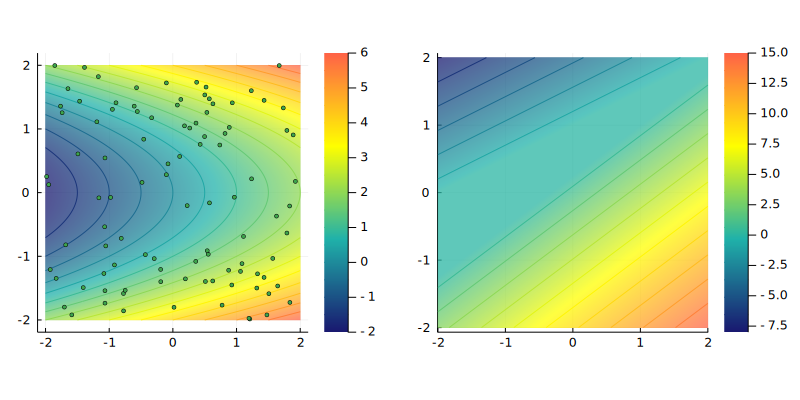

In [6]:
n = 100
X = [rand(Uniform(-2, 2), n) rand(Uniform(-2, 2), n)]
y = [x[1] + x[2]^2 + 0.1rand() for x in eachrow(X)];
visualize(θ)
scatter!(X[:, 1], X[:, 2], ms = 2, msw = 0.5, legend = false)

In [7]:
W₁ = [a b; c d]
W₂ = [e, f]'
b₁ = [g, h]
b₂ = i
ReLU(x) = sympy.Piecewise((x, x ≫ 0), (0, x ≦ 0))
N(x, W₁, W₂, b₁, b₂) = W₂*ReLU.(W₁*x + b₁) + b₂
substitute(x, θ) = float(x(θ...))

substitute (generic function with 1 method)

(a) Use SymPy to calculate the empirical mean squared error. You'll find that it's a large piecewise expression. Apply the function `substitute` to this expression to obtain an actual number.

In [8]:
x = X[1, :]
y[1]

1.3652527777357972

In [9]:
function mse()
end
mse()

20.18894521063058

(b) Write a function which differentiates the mean squared error with respect to each parameter in `θ`. Use these derivatives to adjust the `θ` values repeatedly.

In [10]:
function loss_derivatives(θ)
end
loss_derivatives(θ)

9-element Array{Float64,1}:
  3.3549996514267217
 -5.721787154396251 
 -1.407400312665045 
  3.7497687712026946
 37.38288634020425  
 -8.63963605471182  
  4.430738768339074 
  2.2935599138572633
  1.7455515833445896

(c) Confirm that if you adjust `a` upwards slightly, then the mse value changes in a manner consistent with the derivative you just found. 

What we would like to do at this stage is update the parameter values (`θ`) to get them closer to a set of values which will allow us to match the actual regression function well. However, this is not feasible, because (as you might have noticed already), the symbolic differentiation is painfully slow. We need a much faster way to compute derivative of the loss function with respect to each parameter. Although it is possible to do this with dual numbers, we will do it by hand. 

Before doing that, however, we'll take a look at a website that does in-browser neural net training with a helpful visualization.

## Problem 2

Visit the [TensorFlow playground](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=3&seed=0.80749&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) (use the given link, because the URL includes parameter settings) and answer the following questions. 

(a) About how many epochs does it take for the network to discover the radial structure of the dataset?

(b) What happens if we drop down to two neurons in the hidden layer?

(c) What about if we use two neurons but include the squares of the features?

(d) Come up with your own question about neural network training, and experiment in the TensorFlow playground to answer it. 


*Solution*. 

The key idea for organizing this process is the **chain rule**, which says that we can differentiate compositions by differentiating each function being composed and multiply the derivatives. In other words, we replace each map in the composition with its derivative, and just multiply those derivatives in the same order as the original composition. This makes sense: differentiating can be thought of as linearizing a function, and linear functions compose by matrix multiplication:

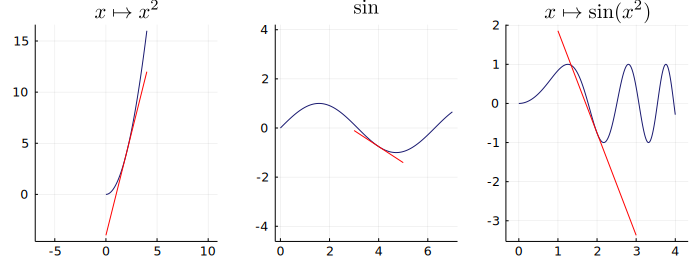

In [11]:
function chainruleviz()
    p1 = plot(0:0.01:4, x -> x^2, legend = false, ratio = 1, title = L"x\mapsto x^2")
    plot!(p1, 0:0.01:4, x -> 4(x-2)+4, linecolor = :red)
    p2 = plot(0:0.01:7, sin, legend = false, ratio = 1, title = L"\sin")
    plot!(p2, 3:0.01:5,  x -> cos(4)*(x-4)+sin(4), linecolor = :red)
    p3 = plot(0:0.01:4, x -> sin(x^2), legend = false, ratio = 1, title = L"x\mapsto \sin(x^2)")
    plot!(p3, 1:0.01:3,  x -> 4*cos(4)*(x-2)+sin(4), linecolor = :red)
    plot(p1, p2, p3, layout = (1,3), size = (700, 265))
end
chainruleviz()

Bearing this in mind, our goal will be to differentiate each map in the neural network's computational graph (the figure shows a multilayer perceptron with more layers): 

<center>
    <img src="nn.svg">
</center>

## Problem 3

* Find the derivative of $C_i(\mathbf{y}) = |\mathbf{y} - \mathbf{y}_i|^2$ with respect to $\mathbf{y}$.
* Find the derivative of $K.$ (the map which applies $K$ pointwise).
* Find the derivative of $\mathbf{u} \mapsto W \mathbf{u} + \mathbf{b}$.

---

## Problem 4

In this problem, we will use **stochastic gradient descent** (SGD) to train a multilayer perceptron. The idea of SGD is to nudge each weight or bias value in whichever direction decreases the loss function (just like gradient descent), but for performance reasons, we'll use a subset of the observations (called a *batch* or *mini-batch*) rather than using all of them. 

We'll build this tool in a general way, so here's a larger neural network diagram (same as above): 

<center>
    <img src="nn.svg">
</center>

We begin by making types to represent neural networks and affine maps. 

In [12]:
struct AffineMap
    W::Matrix
    b::Vector
end
struct NeuralNet
    maps::Vector{AffineMap}
    K::Function # activation function
    K̇::Function # derivative of K
end
(A::AffineMap)(x) = A.W * x + A.b
(N::NeuralNet)(x) = forwardprop(N,x)[end]
architecture(N::NeuralNet) = [[size(A.W,2) for A in N.maps]; size(last(N.maps).W,1)]

architecture (generic function with 1 method)

In [13]:
W₁ = [3.0 -4; -2 4]
W₂ = [1.0 -1]
b₁ = [1.0, -4]
b₂ = [0.0];
K(x) = x > 0 ? x : 0
K̇(x) = x > 0 ? 1 : 0 
NN = NeuralNet([AffineMap(W₁, b₁), AffineMap(W₂, b₂)], K, K̇)

NeuralNet(AffineMap[AffineMap([3.0 -4.0; -2.0 4.0], [1.0, -4.0]), AffineMap([1.0 -1.0], [0.0])], K, K̇)

(a) Complete following forward propagation function.

In [14]:
"""
Return the array of activations obtained by applying
each layer of the neural network to the given input.
"""
function forwardprop(N::NeuralNet,x)
    activations = [x] 
    for (j,A) in enumerate(N.maps)
    end
    activations
end

@test forwardprop(NN, [-2.0, -3]) == [[-2, -3], [7, -12], [7, 0], [7], [7]]
activations = forwardprop(NN, [-2.0, -3])

5-element Array{Array{Float64,1},1}:
 [-2.0, -3.0]
 [7.0, -12.0]
 [7.0, 0.0]  
 [7.0]       
 [7.0]       

(b) Complete following function, which performs backpropagation.

In [15]:
"Index of jth green node"
greennode(j) = 2j-1
"Index of jth purple node"
purplenode(j) = 2j

"""
Compute the gradient of each composition of maps from 
an intermediate node to the final output.
"""
function backprop(N::NeuralNet,activations,yᵢ)
    y = activations[end]
    grads = [2(y-yᵢ)']
    for j = length(N.maps) : -1 : 1
        if j == length(N.maps)
            push!(grads, grads[end])
        else
            push!(grads, grads[end] * Diagonal(N.K̇.(activations[purplenode(j)])))
        end
        push!(grads, grads[end] * N.maps[j].W)
    end
    reverse(grads)
end

backprop(NN, activations, [2.0])

5-element Array{Adjoint{Float64,Array{Float64,1}},1}:
 [30.0 -40.0]
 [10.0 -0.0] 
 [10.0 -10.0]
 [10.0]      
 [10.0]      

The last derivatives to compute are the ones with respect to the weight matrices and bias vectors. If $\mathbf{f}$ is a vector-valued function of a matrix $W$, then $\frac{\partial}{\partial W}(\mathbf{f}(\mathbf{v}))$ is "matrix" whose $(i,j,k)$ th entry is $\frac{\partial f_i}{\partial a_{j,k}}$. As suggested by the scare quotes, this is not really a matrix, since it has three varying indices instead of two. This is called a **third-order tensor**, but we will not develop this idea further, since the only property we will need is suggested by the notation and the result of the exercise above: differentiating $W \mathbf{v}$ with respect to $W$ and left-multiplying by a row vector $\mathbf{u}'$ has the following net effect:

$$
  \mathbf{u}'\frac{\partial}{\partial W}(W \mathbf{v}) =
  \frac{\partial}{\partial W}(\mathbf{u}'W \mathbf{v}) =
  \mathbf{u} \mathbf{v}'.
$$

In [16]:
"Compute the gradients of the cost with respect to each weight matrix"
function weight_gradients(N::NeuralNet,activations,grads)
    [grads[purplenode(j)]' * activations[greennode(j)]' for j=1:length(N.maps)]
end

"Compute the gradients of the cost with respect to each bias"
function bias_gradients(N::NeuralNet,grads)
    [grads[purplenode(j)]' for j=1:length(N.maps)]
end

bias_gradients

In [17]:
"""
Compute the average suggested change to the weight matrices
and bias vectors based on the observations in `batch`. 
"""
function averageweightΔ(N::NeuralNet,observations,batch,ϵ)
    arch = architecture(N)
    layers = length(arch)-1
    sum_Δweight = [zeros(arch[i+1],arch[i]) for i=1:layers]
    sum_Δbias = [zeros(arch[i+1]) for i=1:layers]
    for k in batch
        x, y = observations[k]
        activations = forwardprop(N,x)
        grads = backprop(N,activations,y)
        ΔWs = -ϵ*weight_gradients(N,activations,grads)
        Δbs = -ϵ*bias_gradients(N,grads)
        for i=1:layers
            sum_Δweight[i] += ΔWs[i]
            sum_Δbias[i] += Δbs[i]
        end
    end
    (sum_Δweight, sum_Δbias) ./ length(batch)
end

averageweightΔ

(c) Complete the following function to perform stochastic gradient descent on the network parameters. 

In [18]:
"""
Create a neural network with given architecture and activation and train it 
on `observations`.
"""
function train(arch,K,K̇,observations,batchsize,ϵ = 0.1,iterations=1000)
    random_maps = [AffineMap(randn(arch[i+1],arch[i]),
                             fill(0.1,arch[i+1])) for i=1:length(arch)-1]
    N = NeuralNet(random_maps,K,K̇)
    for i=1:iterations
        #batch = 
        meanΔweight, meanΔbias = averageweightΔ(N,observations,batch,ϵ)
    end
    N
end

train

In [19]:
K(x) = x > 0 ? x : 0
K̇(x) = x > 0 ? 1 : 0 
cost(N::NeuralNet,observations) = mean(norm(N(x)-y)^2 for (x,y) in observations)

cost (generic function with 1 method)

In [20]:
xs = [rand(Uniform(-2,2), 2) for i=1:1000]
ys = [[x[1] + x[2]^2] for x in xs]
observations = collect(zip(xs,ys));

In [21]:
using Random; Random.seed!(1234)
arch = [2,2,1]
batchsize = 100
ϵ = 0.005
NN = train(arch, K, K̇, observations, batchsize, ϵ, 10_000)

NeuralNet(AffineMap[AffineMap([0.6092482582482827 1.4875799557617115; 0.4378903537546946 -1.085086639274379], [0.13040599960398053, 0.040702368903734534]), AffineMap([1.5272096449467576 2.143854325796305], [-1.2240252998160552])], K, K̇)

(d) Plot the trained model and compare to the actual regression function. 

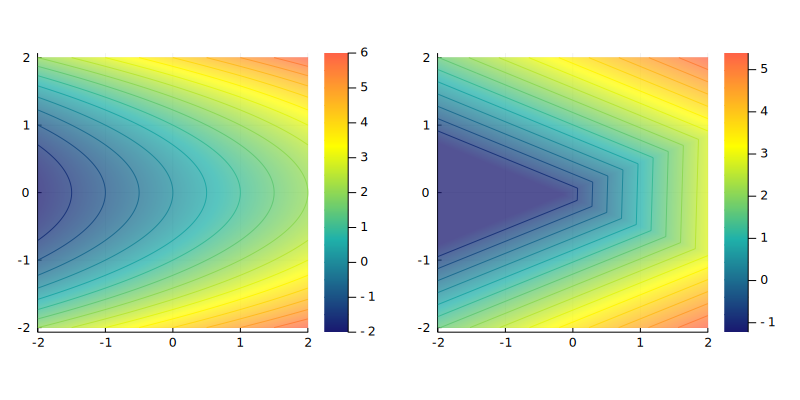

In [22]:
p1 = heatmap(-2:0.01:2, -2:0.01:2, (x,y) -> x + y^2, 
                 ratio = 1, fillopacity = 0.75)
contour!(p1, -2:0.01:2, -2:0.01:2, (x,y) -> x + y^2)
p2 = heatmap(-2:0.01:2, -2:0.01:2, (x,y) -> NN([x,y])[1], 
             fillopacity = 0.75, ratio = 1)
contour!(p2, -2:0.01:2, -2:0.01:2, (x,y) -> NN([x,y])[1])
plot(p1, p2, layout = (1, 2), size = (800, 400))